![Banner](./img/AI_Special_Program_Banner.jpg)

# Feature Engineering - Material
---

Feature engineering describes the process of obtaining new features to improve prediction models. The focus of feature engineering is therefore on the **data** and less on the ML algorithms. In practice, feature engineering is a key success factor for ML models. Obtaining predictive new features is an exploratory process and often requires appropriate domain knowledge. In this teaching unit, we will take a closer look at some well-known and frequently used methods.

This unit is based on the Kaggle course [Feature Engineering](https://www.kaggle.com/learn/feature-engineering) von Ryan Holbrook.

## Table of contents
---

- [Introduction Feature Engineering](#Introduction-Feature-Engineering)
    - [Goal of feature engineering](#Goal-of-feature-engineering)
    - [A guiding principle of feature engineering](#A-guiding-principle-of-feature-engineering)
    - [A first example: concrete data](#A-first-example:-concrete-data)
- [Feature Selection](#Feature-Selection)
    - [Example: 1985 Automobile](#Example:-1985-Automobile)
- [Feature Engineering: Creation of new features](#Feature-Engineering:-Creation-of-new-features)
    - [Mathematical transformations](#Mathematical-transformations)
    - [Countable events](#Countable-events)
    - [Combining and separating features](#Combining-and-separating-features)
    - [Dealing with missing values](#Dealing-with-missing-values)
    - [More ideas](#More-ideas)
    - [General tips and other resources](#General-tips-and-other-resources)
- [Learning outcomes](#Learning-outcomes)

# Introduction Feature Engineering
---

## Goal of feature engineering

The combination and transformation of existing features (*attributes*) into new features is referred to as the process of [*feature engineering*](https://en.wikipedia.org/wiki/Feature_engineering). The aim of feature engineering is to transform the data into a form that better represents the problem at hand. An example of such a *constructed* feature could be [apparent temperature](https://en.wikipedia.org/wiki/Apparent_temperature). To obtain the apparent temperature as a measure of "thermal well-being", we combine different attributes around temperature (wind chill, humidity, etc.). This gives us a combination feature that better represents the observed data for what we are really interested in: how it actually feels to be outside.

Feature engineering leads to several advantages in the context of machine learning:
* Improvement of prediction performance
* Reduction of calculation complexity and duration
* Improving the interpretation of results

The improvement in prediction performance in particular should not be neglected. This makes feature engineering indispensable for high-performance models and is essential for success in [Kaggle competitions](https://www.kaggle.com/competitions). The Kaggle competition by [Rossmann](https://www.kaggle.com/c/rossmann-store-sales) provides a good first impression of the importance of feature engineering. For the prediction of future sales in the Rossmann stores, the synthesis of new features led to the best models. See a summary of the results from the podium places [here](http://www.johnatate.com/learning-from-the-best-rossman-sales-kaggle-winners.html).

## A guiding principle of feature engineering

For a feature to be useful, it must have a relationship to the target that can be learned by the model. Linear models, for example, can only learn linear relationships. If such a model is used, the features should be transformed so that the relationship to the target becomes linear.

The key idea here is that a transformation applied to a feature basically becomes part of the model itself. For example: we want to predict the price of square land based on the length of a side. Fitting a linear model directly to the length gives poor results: The relationship is not linear:

![FE1](img/fe1.png)

[Image source](https://www.kaggle.com/ryanholbrook/what-is-feature-engineering)

However, if we square the feature `Length` to get `Area`, a linear relationship is created. Adding `Area` to the attributes means that this linear model can now fit a parabola. So squaring a feature gives the linear model the ability to fit quadratic features.

![FE2](img/fe2.png)

[Image source](https://www.kaggle.com/ryanholbrook/what-is-feature-engineering)

Any relationships that the model cannot learn, we can provide ourselves through transformations. When we develop our features, we need to think about what information the model could use to achieve its best performance.

## A first example: concrete data

To illustrate these ideas, we can look at how adding some synthetic features to a dataset can improve the predictive performance of a *random forest model*.

**Note:** We will first learn about the random forest model formally in the **Ensemble Learning** unit. However, the actual model is not relevant for the following demonstration. In short, the random forest model is based on a combination of decision trees and is a very powerful model that requires few adjustments.

The following dataset on [Concrete](https://www.kaggle.com/sinamhd9/concrete-comprehensive-strength) contains a variety of concrete mix designs and the compressive strength of the resulting product, which is a measure of how much load the concrete can carry. The task for this data set is to predict the `CompressiveStrength` of a concrete based on its mix design.

In [1]:
%matplotlib inline
import pandas as pd

In [2]:
concrete = pd.read_csv('./data/concrete.csv')
concrete.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


Here we can look at the different components that go into each type of concrete. Below we will create some synthetic features derived from these. These will help the model to learn important relationships between the features.

We will first establish a **baseline** by training the model with the unexpanded dataset. This will allow us to determine whether our new features are actually useful.

Creating baselines like this is good practice at the beginning of the feature engineering process. A baseline score can help decide whether new features are worth keeping or whether we should discard them and possibly try something else.

Please note that this is a **regression**, i.e. the prediction of a continuous value. So we need to choose other metrics to assess performance. The **Mean Absolute Error (MAE)** was used here.

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

X = concrete.copy()
y = X.pop("CompressiveStrength")

# Train and score baseline model
baseline = RandomForestRegressor(criterion="absolute_error", random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="neg_mean_absolute_error"
)
baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 8.232


When cooking, the ratio of ingredients is often more important than the absolute quantities. By calculating ratios, we can make "hidden" information available for our ML model. The new ratio features should of course be *meaningful* in relation to the respective use case (keyword: **domain knowledge**).

Here we add three new features based on ratios:

In [4]:
# Create synthetic features
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(criterion="absolute_error", random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")

MAE Score with Ratio Features: 7.948


This actually leads to an improvement in prediction quality. However, not all models benefit equally from new ratio attributes.

In the following, we will take a look at which features can possibly be combined with each other.

# Feature Selection
---

Finding promising features for a combination in the form of ratio attributes is not always easy - especially with high-dimensional data. One possible starting point could be **feature selection** methods. This is actually primarily about selecting features with a high predictive value in order to reduce the dimension of the data. The main goal is to reduce the training and inference time (the time it takes to make a prediction).  
We can illustrate this with an example (based on [this tutorial](https://inria.github.io/scikit-learn-mooc/python_scripts/feature_selection_introduction.html)):

First, we generate a synthetic dataset where we can customize the number of informative, repeated and random features:

In [5]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=5000,
    n_features=100,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    random_state=0
)

Furthermore, we create a random forest model, which is trained with the entire data ($\hat =$ no feature selection):

In [6]:
from sklearn.ensemble import RandomForestClassifier

model_without_selection = RandomForestClassifier(n_jobs=-1, random_state=0)

We use [**mutual information**](https://en.wikipedia.org/wiki/Mutual_information) as the feature selection method. This procedure is again based on Shannon's information theory and is closely related to entropy. It measures the reduction of uncertainty for the value of one variable for known values of a second variable. Formally, the mutual information $I$ for two random variables $X$ and $Y$ is defined as:

$I(X;Y) = H(X) - H(X|Y)$

Where $H(X)$ is the entropy of $X$ and $H(X|Y)$ is the conditional entropy of $X$, given $Y$. The following properties should be considered when using the transinformation:

* It is possible for a feature to be very informative when it interacts with other features, but not so informative on its own. Mutual information cannot detect interactions between features ([multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)). It is a univariate metric.
* Mutual information also recognizes non-linear relationships between two features (unlike covariance, for example).

First, we create a pipeline from the feature selection and RF model:

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.pipeline import make_pipeline


model_with_selection = make_pipeline(
    SelectKBest(score_func=mutual_info_classif, k=2),
    RandomForestClassifier(n_jobs=-1, random_state=0),
)

In the following, we measure the training and inference time of both models, as well as the cross-validated accuracy.

Random-Forest **without Feature Selection**:

In [8]:
from sklearn.model_selection import cross_validate

cv_results_without_selection = cross_validate(model_without_selection, X, y)
cv_results_without_selection = pd.DataFrame(cv_results_without_selection)

Pipeline **with Feature Selection**:

In [9]:
cv_results_with_selection = cross_validate(
    model_with_selection, X, y, return_estimator=True)
cv_results_with_selection = pd.DataFrame(cv_results_with_selection)

Summary of the results in a dataframe:

In [10]:
cv_results = pd.concat(
    [cv_results_without_selection, cv_results_with_selection],
    axis=1,
    keys=["Without feature selection", "With feature selection"],
)
# swap the level of the multi-index of the columns
cv_results = cv_results.swaplevel(axis="columns")

The resulting DataFrame:

In [11]:
cv_results

,fit_time,score_time,test_score,fit_time,score_time,estimator,test_score
,Without feature selection,Without feature selection,Without feature selection,With feature selection,With feature selection,With feature selection,With feature selection
0,0.568121,0.013066,0.973,0.882355,0.013335,"(SelectKBest(k=2, score_func=<function mutual_...",0.981
1,0.549495,0.013361,0.972,0.844841,0.013093,"(SelectKBest(k=2, score_func=<function mutual_...",0.981
2,0.551129,0.013373,0.976,0.850654,0.013197,"(SelectKBest(k=2, score_func=<function mutual_...",0.973
3,0.533441,0.013198,0.958,0.847196,0.013250,"(SelectKBest(k=2, score_func=<function mutual_...",0.968
4,0.555110,0.013141,0.964,0.845393,0.013146,"(SelectKBest(k=2, score_func=<function mutual_...",0.976


**Training duration** of both models:

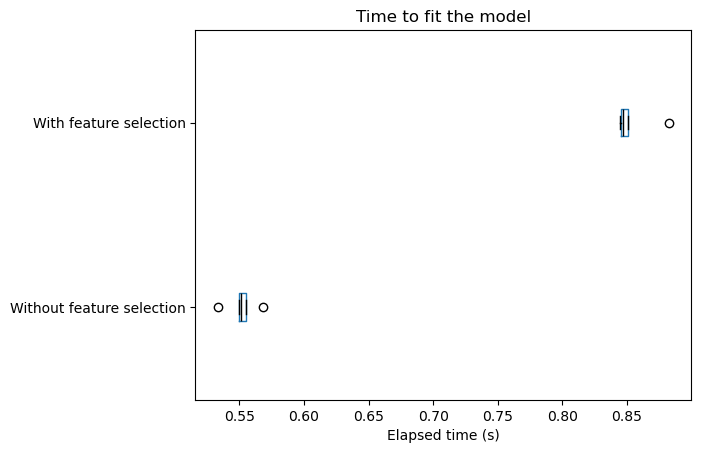

In [12]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
cv_results["fit_time"].plot.box(color=color, vert=False)
plt.xlabel("Elapsed time (s)")
plt.title("Time to fit the model")
plt.show()

In fact, the training time with feature selection is about 50% longer! This is because the calculation of the mutual information is an NP-hard problem (further information [here](https://thuijskens.github.io/2017/10/07/feature-selection/) and [here](https://openproceedings.org/2018/conf/edbt/paper-27.pdf)) and is estimated using non-parametric methods. Thus, the complexity of feature selection exceeds that of the ML model. If the primary goal is to reduce the training time, a different method should be chosen (see the comparison [here](https://inria.github.io/scikit-learn-mooc/python_scripts/feature_selection_introduction.html) with the much more efficient *analysis of variance* (*ANOVA*)).

**Reference duration** of both models:

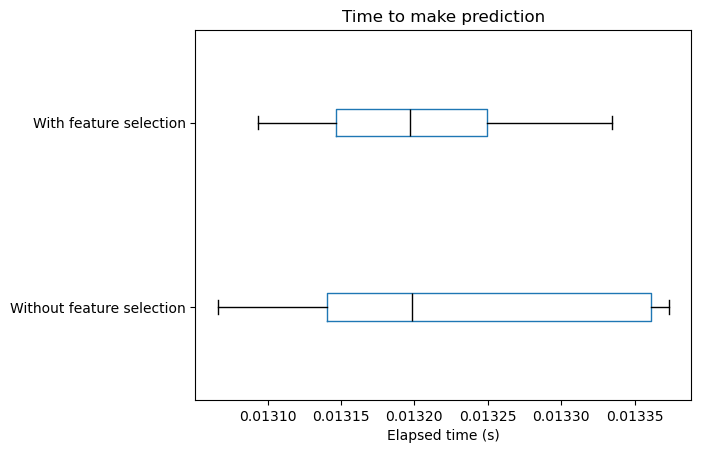

In [13]:
cv_results["score_time"].plot.box(color=color, vert=False)
plt.xlabel("Elapsed time (s)")
plt.title("Time to make prediction")
plt.show()

However, once the features are reduced, we get faster inference times. Let's also take a look at the test accuracies:

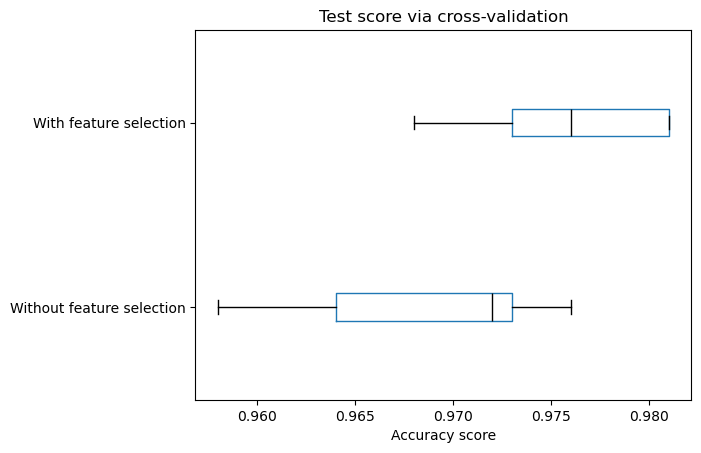

In [14]:
cv_results["test_score"].plot.box(color=color, vert=False)
plt.xlabel("Accuracy score")
plt.title("Test score via cross-validation")
plt.show()

By removing the uninformative features (*noise*), we actually get better model performance in this case. Models based on decision trees are actually quite robust against noise in the training data. This could result in even greater performance gains for other ML models.

In [15]:
import numpy as np

for idx, pipeline in enumerate(cv_results_with_selection["estimator"]):
    print(
        f"Fold #{idx} - selected features: "
        f"{np.argsort(pipeline[0].scores_)[-2:]}"
    )

Fold #0 - selected features: [22 53]
Fold #1 - selected features: [22 53]
Fold #2 - selected features: [22 53]
Fold #3 - selected features: [22 53]
Fold #4 - selected features: [22 53]


The relevant features are extracted for all splits using the mutual information. This is not always successful for weaker methods (see [here](https://inria.github.io/scikit-learn-mooc/python_scripts/feature_selection_introduction.html)).

**Note:** Only one of many feature selection methods has been demonstrated here. Just like ML models themselves, all feature selection methods have their advantages and disadvantages and should therefore be examined before each specific use case.`Scikit-learn` provides many more methods [available](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection).

## Example: 1985 Automobile

In the following, we will look at the mutual information values in a real dataset. We consider the [Automobile](https://www.kaggle.com/toramky/automobile-dataset) dataset, which contains 193 vehicles built in 1985. The goal of this dataset is to predict the `price`, based on 24 vehicle characteristics.

In [16]:
import seaborn as sns

#plt.style.use("seaborn-whitegrid")

autos = pd.read_csv("./data/automobile.csv")
autos.head()

,symboling,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130.0,mpfi,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,13495.0
1,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130.0,mpfi,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,16500.0
2,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152.0,mpfi,2.68,3.47,9.0,154.0,5000.0,19.0,26.0,16500.0
3,2,audi,gas,std,four,sedan,fwd,front,99.8,176.6,...,109.0,mpfi,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0
4,2,audi,gas,std,four,sedan,4wd,front,99.4,176.6,...,136.0,mpfi,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0


Fortunately, mutual information is flexible when dealing with numerical or categorical variables. In the example shown here, we use integer encoding for the sake of simplicity. Normally, however, one-hot encoding is preferable!

In [17]:
X = autos.copy()
y = X.pop("price")

# Integer encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

Since this example is a regression (which plays a role in the calculation of the mutual information), we select `mutual_info_regression` as the method:

In [18]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show some feature with transinformation value 

engine-size    0.910567
highway-mpg    0.882411
length         0.607227
fuel-system    0.480715
height         0.356468
symboling      0.228783
engine-type    0.151544
fuel-type      0.048139
Name: MI Scores, dtype: float64

This can be illustrated more clearly with a plot:

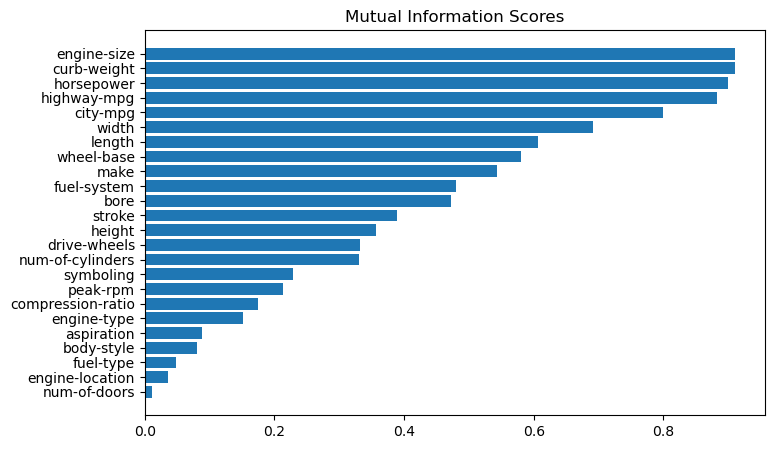

In [19]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

curb-weight is the total weight of the vehicle. The strong correlation with `price` does not seem surprising. We can look at this with the help of a scatterplot:

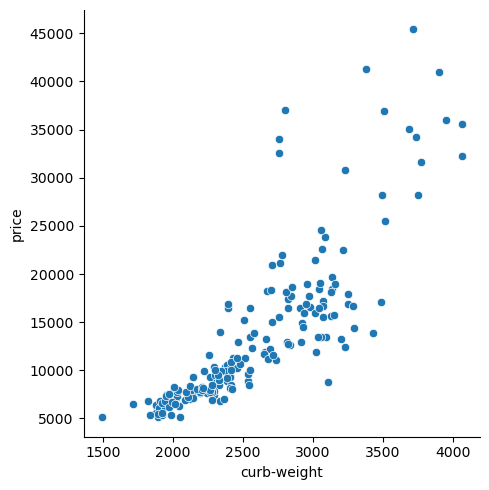

In [20]:
import seaborn as sns
sns.relplot(x="curb-weight", y="price", data=autos)
plt.show()

The feature `fuel_type` has a relatively low mutual information value, but as we can see in the figure below, it clearly separates two price populations with different trends within the feature `horsepower`. This suggests that `fuel-type` contributes an interaction effect and may not be unimportant after all. Before deciding that a feature is unimportant based on the mutual information value, possible interaction effects should be investigated - domain knowledge can be of great help here.

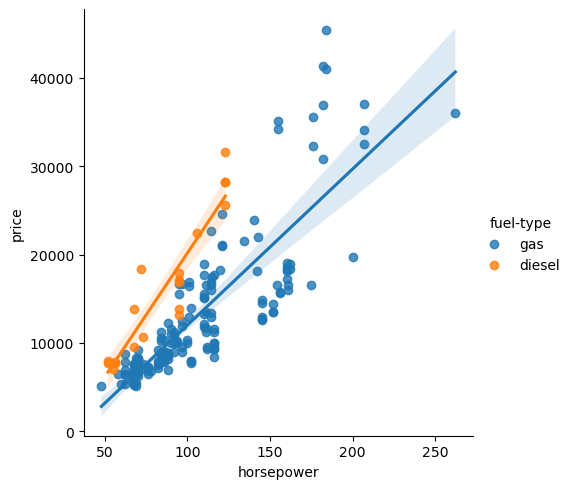

In [21]:
sns.lmplot(x="horsepower", y="price", hue="fuel-type", data=autos)
plt.show()

In this section, we have learned methods that can help us select potentially important features. In the following, we will look at how we can now create new features on the basis of such features.

# Feature Engineering: Creation of new features
---

The creation/transformation of new features based on existing features is at the heart of the feature engineering process. In this section, we look at some transformations that can be expected to have a positive impact on ML models. We use four different datasets, (with `automobile` and `concrete` already imported above). In addition, we look at data on [traffic accidents](https://www.kaggle.com/sobhanmoosavi/us-accidents) in the USA and data on [customer lifetime value](https://www.kaggle.com/pankajjsh06/ibm-watson-marketing-customer-value-data).

In [22]:
#plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

accidents = pd.read_csv("./data/accidents.csv")
customer = pd.read_csv("./data/customer.csv")

Below we will take a look at some useful transformations of features. However, the possibilities for developing new types of features are unlimited. It is therefore not always clear which feature combinations and transformations make sense. Here are some **tips** that can be helpful when discovering new features:

* Build up an understanding of the individual features. If necessary, check the data documentation.
* **Domain knowledge** is the most important factor when creating features. Extensive research using books, journals, articles and of course dialog with experts can strengthen your knowledge.
* Research related work in the field. For example, the [explanation of solutions](https://www.kaggle.com/sudalairajkumar/winning-solutions-of-kaggle-competitions) for past Kaggle competitions is a great resource.
* Use of visualizations. Visualization can reveal pathologies in the distribution of a feature or complicated relationships that could be simplified.

## Mathematical transformations

Relationships between numerical features are often expressed by mathematical formulas, which we will encounter frequently in our domain research. In the Automobile dataset, there are features that describe the engine of a car. After researching, we find out that the stroke-bore ratio is a known characteristic of an engine and has an impact on its operating behavior. Applying the formula to the known features results in a new feature:

In [23]:
autos["stroke_ratio"] = autos['stroke'] / autos['bore']

autos[["stroke", "bore", "stroke_ratio"]].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


The more complicated a combination is, the more difficult it is for a model to learn, like this formula for the *displacement* of an engine:

In [24]:
autos["displacement"] = (
    np.pi * ((0.5 * autos['bore']) ** 2) * autos['stroke'] * autos['num-of-cylinders']
)

**Skewed distributions** of features are a common problem for ML models. This particularly affects [log-normally distributed](https://en.wikipedia.org/wiki/Log-normal_distribution) features (*long-tailed*), which frequently occur in the natural sciences, technology and economics due to multiplicative laws. A common example of this is *prices* or *income*. Most of the values lie in a fairly small range, but there is hardly any upper limit. This large distance leads to problems with scaling, among other things, as the distance ratios are compressed by the scaling. In these cases, it can help to logarithmize in order to aim for a normal distribution. Here using the example of `price` in the car data set:

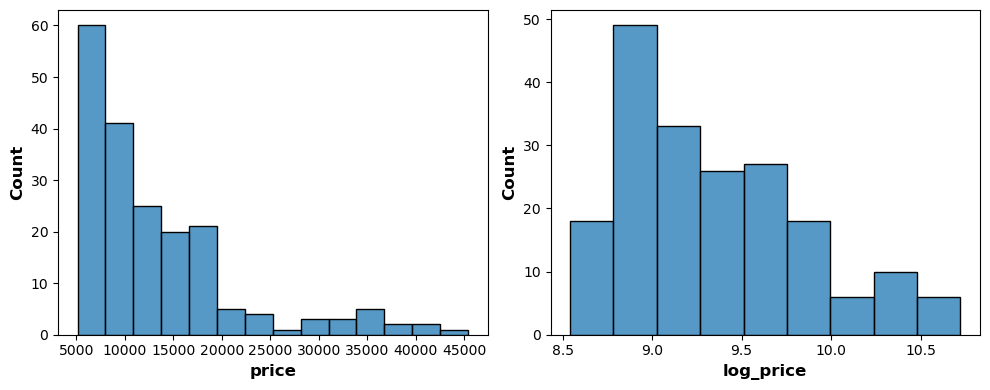

In [25]:
# np.log1p (log(1+x)) anstatt np.log wegen Nullwerten!
autos['log_price'] = np.log1p(autos['price']) 

fig,axs = plt.subplots(1,2,figsize=(10,4))

sns.histplot(autos['price'], ax=axs[0])
sns.histplot(autos['log_price'], ax=axs[1]);

The transformation has reduced the skew and the dynamic range of the distribution.

 This approach is particularly popular for **class variables** (prediction of prices or sales, etc.)! See also the application example of the [TransformedTargetRegressor](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html) from `scikit-learn`. It should be noted, however, that the success of such a transformation depends heavily on the error used (see also [here](https://florianwilhelm.info/2020/05/honey_i_shrunk_the_target_variable/)). For more information, see also [Jeremy Howard](https://mlbook.explained.ai/prep.html#logtarget).

## Countable events

Characteristics that describe the presence of something are often summarized in groups, e.g. the group of risk factors for a disease. We can aggregate such features by creating a count. These characteristics are binary (1 for present, 0 for absent) or boolean (True or False). In both cases, we can simply create a sum using Python.

In `accidents` there are several attributes that indicate whether an object on the roadway was near the accident. A count of the total number of roadway attributes in the vicinity is created using the sum method:

In [26]:
roadway_features = ["Amenity", "Bump", "Crossing", "Give_Way",
    "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop",
    "Traffic_Calming", "Traffic_Signal"]
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

accidents[roadway_features + ["RoadwayFeatures"]].head(5)

,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,RoadwayFeatures
0,False,False,False,False,True,False,False,False,False,False,False,False,1
1,False,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,False,False,0


Conversely, we can also generate Boolean values. In the `concrete` data set, the quantities of the components used are specified as floats, but not all components are always used. We can use Pandas [`.gt()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.gt.html) to check which components are greater than zero and count them:

In [27]:
components = [ "Cement", "BlastFurnaceSlag", "FlyAsh", "Water",
               "Superplasticizer", "CoarseAggregate", "FineAggregate"]
concrete["Components"] = concrete[components].gt(0).sum(axis=1)

concrete[components + ["Components"]].head(5)

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,5
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,5
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5


## Combining and separating features

More complex strings often contain several features that can be extracted. Some examples:

* IDs: `123-45-6789`
* Telephone numbers: `0123-456789`
* Addresses: `8241 Kaggle Ln., Goose City, NV`
* URL: `https://dataakademie.de/`
* DateTime formats: `Mon Sep 30 07:06:05 2013`

The structure of such features can easily be used to extract further features. For example, the first digits of the phone number can be used to estimate the location. Below we split the feature `policy` into two new features:

In [28]:
customer[["Type", "Level"]] = (  # Create two new features
    customer["Policy"]           # from the Policy feature
    .str                         # through the string method
    .split(" ", expand=True)     # by splitting on " "
                                 # and expanding the result into separate columns
)

customer[["Policy", "Type", "Level"]].head(5)

,Policy,Type,Level
0,Corporate L3,Corporate,L3
1,Personal L3,Personal,L3
2,Personal L3,Personal,L3
3,Corporate L2,Corporate,L2
4,Personal L1,Personal,L1


The extraction of **date information** can have a particularly strong impact on a forecasting model. For example, if retail sales figures are to be predicted, then the days of the week, days before and after holidays, months, etc. are extremely relevant for the sales achieved. We should not withhold this information from an ML model!

We can use Panda's `.dt` to easily extract valuable date information for the `accidents` data set:

In [29]:
accidents.Start_Time.head()

0    2019-10-30 17:12:00
1    2019-05-19 15:49:40
2    2019-01-28 13:49:37
3    2017-03-24 14:03:46
4    2019-12-07 14:28:33
Name: Start_Time, dtype: object

In [30]:
accidents['Start_Time'] = pd.to_datetime(accidents['Start_Time'], format='ISO8601')

accidents['Year'] = accidents['Start_Time'].dt.year
accidents['Month'] = accidents['Start_Time'].dt.month
accidents['Day'] = accidents['Start_Time'].dt.day
accidents['WeekOfYear'] = accidents['Start_Time'].dt.isocalendar().week
accidents['DayOfYear'] = accidents['Start_Time'].dt.dayofyear

In [31]:
accidents[['Start_Time','Year','Month','Day','WeekOfYear','DayOfYear']].head()

,Start_Time,Year,Month,Day,WeekOfYear,DayOfYear
0,2019-10-30 17:12:00,2019,10,30,44,303
1,2019-05-19 15:49:40,2019,5,19,20,139
2,2019-01-28 13:49:37,2019,1,28,5,28
3,2017-03-24 14:03:46,2017,3,24,12,83
4,2019-12-07 14:28:33,2019,12,7,49,341


Other possible date transformations, as used in the [Rossmann Challenge](https://www.kaggle.com/c/rossmann-store-sales), can be found [here](https://medium.com/analytics-vidhya/rossmann-store-sales-prediction-998161027abf#251f). The predictive power of the additional information was examined [here](http://cs229.stanford.edu/proj2015/215_report.pdf).

## Dealing with missing values

The following three types of missing data are frequently found:

* **Missing Completely at Random (MCAR):** The missing values show no hidden dependence on any other variable or characteristic of the observations. If a physician forgets to record the age of every tenth patient admitted to an ICU, the presence of missing values would not depend on the characteristic of the patients.
* **Missing at Random (MAR):** In this case, the probability of a missing value depends on the characteristics of the observable data. For survey data, high-income respondents are less likely to provide information on the number of properties owned. The missing value for the number of properties owned variable depends on the income variable.
* **Missing Not at Random (MNAR):** This occurs when the missing values depend on both the characteristics of the data and *missing values themselves*. In this case, it is difficult to determine the mechanism of missing value generation. For example, missing values for a variable such as blood pressure may depend in part on blood pressure values because patients with low blood pressure are less likely to have their blood pressure checked frequently.

Additional information on missing values:

* [Video by ritvikmath](https://www.youtube.com/watch?v=XnnA9z7lv4Q&ab_channel=ritvikmath)
* [Official Pandas Guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html)

Missing values are often simply removed from the data records ([pd.dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)) - at least if there are not too many. However, if the values MAR or MNAR are missing, then there is an underlying regularity that we should not withhold from the ML model. If we [impute](https://en.wikipedia.org/wiki/Imputation_(statistics)) missing values, then it makes sense to include another binary feature that indicates whether a value is missing or not.

The columns with the 5 most frequent missing values in `accidents`:

In [32]:
accidents.isna().sum().sort_values(ascending=False)[:5]

End_Lat              6506
End_Lng              6506
Number               6352
Precipitation(in)    4903
Wind_Chill(F)        4519
dtype: int64

For example, if we want to impute `Wind_Chill(F)` with the average value, then the information as to whether the value was missing is lost. We therefore create a new, binary feature beforehand:

In [33]:
accidents['Wind_Chill(F)_missing'] = accidents['Wind_Chill(F)'].isna()
accidents['Wind_Chill(F)'].fillna(accidents['Wind_Chill(F)'].mean(), inplace=True)

In [34]:
accidents[['Wind_Chill(F)', 'Wind_Chill(F)_missing']].head(7)

,Wind_Chill(F),Wind_Chill(F)_missing
0,25.000000,False
1,90.000000,False
2,54.846251,True
3,38.600000,False
4,41.000000,False
5,30.600000,False
6,54.846251,True


## More ideas

Additional ideas for feature engineering, not all of which we can explicitly cover in this unit:

* Use of moving averages, see e.g. [here](https://medium.com/kaggle-blog/rossmann-store-sales-winners-interview-2nd-place-nima-shahbazi-ad7a4eb65629)
* Clustering, see e.g. [here](https://www.kaggle.com/ryanholbrook/clustering-with-k-means)
* PCA, see e.g. [here](https://www.kaggle.com/ryanholbrook/principal-component-analysis)
* Extraction of information from geodata (e.g. coordinates from ZIPs, etc.)

## General tips and further resources

Finally, a few **general tips** for creating features (see [here](https://www.kaggle.com/ryanholbrook/creating-features)):

* Linear models learn sums and differences naturally, but cannot learn more complex relationships.
* Ratios seem to be difficult to learn for most models. Ratio combinations often lead to performance improvements.
* Tree-based models can learn to approximate almost any combination of features. However, if one combination is particularly important, it can still help to create it explicitly (especially when data is scarce).
* Counts are particularly helpful for tree models, as these models have no natural way to aggregate information about many features at once.

**Further Ressources**

* [Post by Jason Brownlee](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)
* Online book [Feature Engineering and Selection](http://www.feat.engineering/index.html) by Max Kuhn and Kjell Johnson
* Further [examples](https://medium.com/analytics-vidhya/rossmann-store-sales-prediction-998161027abf#251f) for feature engineering for the Rossmann data

## Learning outcomes
---

The most important learning objectives of this unit at a glance:

* Feature engineering can vastly improve prediction models by transforming existing features or creating new ones,
* it is more of an art than an exact science and often requires domain knowledge to create features with strong predictive values,
* there are many possible ways to create new features from mathematical transformations, counting, combining or splitting features, and dealing with missing values.
* to get a crasp of the many possible applications of feature engineering, researching related works and success stories of feature engineering is necessary.